<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/colab_ANN_with_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with FFT

in this note book i will use the regular Dense neural network with the FT as input 
the FT with be sliced to the f = 200



In [109]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft

In [110]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

Cloning into 'EEG-computation'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (377/377), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 377 (delta 14), reused 351 (delta 2), pack-reused 0
Receiving objects: 100% (377/377), 579.80 MiB | 39.69 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (339/339), done.
/content/EEG-computation/EEG-computation


In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])

        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
        
        
data = {"N":channels_normal,
      "D":channels_disorder}

In [0]:
n_D , n_N = len(data['D']), len(data['N'])

## Making Fourier Transform data set

In [118]:
index = np.arange(0,512*30)
f = np.linspace(0,512,512*30)
f_max = f[len(f[f<120])]
ind_min = 2
ind_max = list(index[f==f_max])[0]
f_min = f[ind_min]

print(f_min, f_max, ind_min, ind_max)


sam_FT = np.abs(fft(data['D'][1][6]))

# The 50 Htz noise elimination information

noise = f[sam_FT == np.max(sam_FT[list(f<55) and list(f>45)])][0]
noise_index = list(index[f==noise])[0] # in range 0, 512*30
del_domain = 40
del_range = [noise_index + i for i in range(-del_domain,del_domain)]
print(noise, noise_index)








0.06667100722703301 120.00781300865941 2 3600
49.96991991666124 1499


In [0]:
f = np.linspace(0,512,512*30)[ind_min:ind_max]

In [0]:
normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


FT = {'D':disorder,
     'N':normal}

from numpy.fft import fft

for d in range(n_D):
    for i in range(19):
        
        FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
        FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
        FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])
    
for n in range(n_N):
    for i in range(19):
        FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
        FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
        FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])
        

    FT['N'] = np.array(FT['N'])
    FT['D'] = np.array(FT['D'])

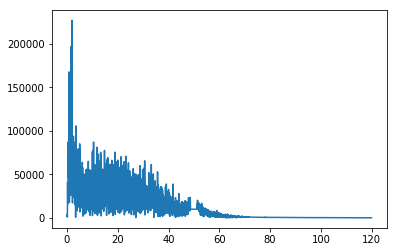

In [121]:
plt.plot(f, FT['N'][6][9])

In [0]:
%reset_selective -f "^data$"

# Data Shaper

In [123]:
FT['N'].shape

(132, 19, 3598)

In [0]:
FT_matrix_N = FT['N']
FT_matrix_D = FT['D']


In [0]:
for n in range(n_N):
    FT_matrix_N[n] = FT['N'][n]
for d in range(n_D):
    FT_matrix_D[d] = FT['D'][d]

In [0]:
# normal is 1 and disorder is 0
Data = np.vstack((FT_matrix_N, FT_matrix_D))
target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))

In [127]:
Data.shape, target.shape

((328, 19, 3598), (328,))

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = shuffle(Data, target)


((246, 3598, 19), (82, 3598, 19), (246,), (82,))

# Neural Network 

In [0]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

In [0]:
X_train.shape[1]

3598

In [0]:
model = Sequential([
    Flatten(input_shape=[X_train.shape[1],X_train.shape[2]]),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
    
])

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 68362)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 300)               20508900  
_________________________________________________________________
dropout_38 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)             

In [0]:
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
246/246 [==============================] - 633s 3s/step - loss: 7.3312 - acc: 0.5081ETA: 2:50 - loss: 7.3795 - acc: 0.505
Epoch 2/3
246/246 [==============================] - 28s 113ms/step - loss: 7.6468 - acc: 0.4959
Epoch 3/3
246/246 [==============================] - 3s 12ms/step - loss: 7.5298 - acc: 0.5041


In [0]:
a